In [1]:
import pandas as pd
import numpy as np
dt = pd.read_csv('../data/model2.csv')
# откуда то при пересохранении в csv образуется лишний столбец
dt.drop(dt.columns[[0]], axis = 1, inplace = True)
dt.drop('yearsign', axis=1, inplace=True)

# подготовим данные для модели
X = dt.drop(['claim'], axis = 1)
Y = dt.claim

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt


dt.head()

,INS_YEAR,OWN_YEAR,AGR_KBM,TS_POWER,f1_daysbeforestart,f2_AGR_SRC_True,f2_AGR_SRC_False,f3_AGR_CREATEDBY_True,f3_AGR_CREATEDBY_False,f4_TS_CATEGORY_True,...,f22_agr_days,claim,f19_drv_skill_min,f20_drv_skill_max,ABS-WEB: ELT SOAP,Агент РСА,КИАС:WebCustomer,КИАС:WebSale,КИАС:Страхование,РСА: Е-ОСАГО Гарант
0,49.0,49.0,0.85,156.4,3,0.049135,0.111105,0.050685,0.068493,0.05135,...,364,0,10.0,28.0,0,0,0,0,1,0
1,52.0,52.0,0.80,235.0,5,0.049135,0.111105,0.050685,0.068493,0.05135,...,365,0,11.0,29.0,0,0,0,0,1,0
2,52.0,52.0,0.80,235.0,5,0.049135,0.111105,0.041509,0.045283,0.05135,...,365,0,11.0,29.0,0,0,0,0,1,0
3,50.0,50.0,1.00,156.4,6,0.049135,0.111105,0.050685,0.068493,0.05135,...,365,0,0.0,29.0,0,0,0,0,1,0
4,53.0,53.0,0.75,235.0,10,0.049135,0.111105,0.047490,0.087291,0.05135,...,364,0,12.0,30.0,0,0,0,0,1,0


In [2]:
from scipy.optimize import minimize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report,f1_score

def mtr(m, x = X_test, y = y_test, limit = 0, metrics = 'AUC'):
#     print(len(x), len(y))
    pr = m.predict(x)
    meanclaim = 27000
    meanpremium = 5000
#     print(pr)
    if limit == 0:
        pred = pr
    elif limit == 1:
        def min(limit, m=m):
            s = m.predict_proba(x)
            r = []
            for i in s:
                if i[0] > limit:
                    r.append(0)
                else:
                    r.append(1)
            if metrics == 'AUC':
                res = roc_auc_score(y, r)
            elif metrics == 'F1':
                res = f1_score(y, r)
            elif metrics == 'money':
                cm = confusion_matrix(y, r)
                res = (cm[0][0] + cm[1][0])*meanpremium - cm[1][0]*meanclaim
                
            return -res
        l = minimize(min, 0.5, method='COBYLA')['x']
        print ('Оптимальный лимит: ', l)
        print('')
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > l:
                pred.append(0)
            else:
                pred.append(1)
        
    else:
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > limit:
                pred.append(0)
            else:
                pred.append(1)
    cmf = confusion_matrix(y, pred)
    print('Всего денег: ',  (cmf[0][0] + cmf[1][0])*meanpremium - cmf[1][0]*meanclaim)
    print('')
    print(cmf)
    print('')
    print(classification_report(y, pred))
    print('')
    print('ROC-AUC score: ', roc_auc_score(y, pred))

In [3]:
from collections import Counter
Counter(Y)


Counter({0: 78203, 1: 3767})

In [4]:
# попробуем решить задачу ансамблем деревьев
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(max_depth = 30)
modelrf.fit(X_train, y_train)

mtr(modelrf, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.94765390625

Всего денег:  43259000

[[10227  5428]
 [  358   381]]

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     15655
           1       0.07      0.52      0.12       739

    accuracy                           0.65     16394
   macro avg       0.52      0.58      0.45     16394
weighted avg       0.93      0.65      0.75     16394


ROC-AUC score:  0.5844176420784948


In [28]:
mtr(modelrf, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.625

Всего денег:  62128000

[[15598    57]
 [  721    18]]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15655
           1       0.24      0.02      0.04       739

    accuracy                           0.95     16394
   macro avg       0.60      0.51      0.51     16394
weighted avg       0.92      0.95      0.93     16394


ROC-AUC score:  0.5103581151253194


In [65]:
# попробуем другие модели
from sklearn.ensemble import GradientBoostingClassifier
modelgb = GradientBoostingClassifier()
modelgb.fit(X_train, y_train)
mtr(modelgb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.958840234375

Всего денег:  40753000

[[9387 6268]
 [ 281  458]]

              precision    recall  f1-score   support

           0       0.97      0.60      0.74     15655
           1       0.07      0.62      0.12       739

    accuracy                           0.60     16394
   macro avg       0.52      0.61      0.43     16394
weighted avg       0.93      0.60      0.71     16394


ROC-AUC score:  0.6096865817360033


In [26]:
mtr(modelgb, x = X_test, y = y_test, limit = 1, metrics = 'money')

Оптимальный лимит:  0.763671875

Всего денег:  62123000

[[15597    58]
 [  721    18]]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15655
           1       0.24      0.02      0.04       739

    accuracy                           0.95     16394
   macro avg       0.60      0.51      0.51     16394
weighted avg       0.92      0.95      0.93     16394


ROC-AUC score:  0.5103261764475806


In [5]:
from sklearn.neighbors import KNeighborsClassifier
modelknn = KNeighborsClassifier(n_neighbors=20)
modelknn.fit(X_train, y_train)
mtr(modelknn, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.90625

Всего денег:  50158000

[[12280  3375]
 [  511   228]]

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     15655
           1       0.06      0.31      0.11       739

    accuracy                           0.76     16394
   macro avg       0.51      0.55      0.48     16394
weighted avg       0.92      0.76      0.83     16394


ROC-AUC score:  0.5464694795464967


In [34]:
mtr(modelknn, x = X_test, y = y_test, limit = 1, metrics = 'money')

Оптимальный лимит:  0.5

Всего денег:  62017000

[[15655     0]
 [  739     0]]

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15655
           1       0.00      0.00      0.00       739

    accuracy                           0.95     16394
   macro avg       0.48      0.50      0.49     16394
weighted avg       0.91      0.95      0.93     16394


ROC-AUC score:  0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from catboost import CatBoostClassifier

In [36]:
modelcb = CatBoostClassifier(
#         learning_rate=0.1,
        loss_function='Logloss',
        depth=12,
        iterations=50,
        eval_metric='AUC',
#         od_type='Iter',
#         od_wait=40,
#         random_seed=42,
        logging_level='Silent',
        allow_writing_files=False
    )

In [67]:
modelcb.fit(X_train, y_train)
mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.961869921875

Всего денег:  47571000

[[11591  4064]
 [  472   267]]

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     15655
           1       0.06      0.36      0.11       739

    accuracy                           0.72     16394
   macro avg       0.51      0.55      0.47     16394
weighted avg       0.92      0.72      0.80     16394


ROC-AUC score:  0.5508507400567636


In [39]:
modelcb.get_feature_importance(prettified=True,)

,Feature Id,Importances
0,f6_TS_MODEL_NAME_True,5.990932
1,f1_daysbeforestart,5.612679
2,f23_kbm_min,5.547026
3,TS_POWER,5.541861
4,f3_AGR_CREATEDBY_False,5.287403
5,f7_car_age_on_start,4.771248
6,f5_TS_MARK_NAME_False,4.769952
7,f6_TS_MODEL_NAME_False,4.632217
8,f3_AGR_CREATEDBY_True,4.142764
9,f19_drv_skill_min,3.975993


In [8]:
# устраним дисбаланс классов за счет downsampling'а обучающей выборки
import random as r
ds = dt
ds['cat'] = ds['claim'].apply(lambda x: 1 if x==1 else r.choice(list(range(2, 20))))

In [9]:
ds = ds[ds['cat'].isin([1,2])]
Xs = ds.drop(['claim', 'cat'], axis = 1)
Ys = ds.claim

from sklearn.model_selection import train_test_split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, Ys, test_size=0.2, random_state=42)

In [44]:
modelcbs = RandomForestClassifier()
modelcbs.fit(Xs_train, ys_train)
mtr(modelcbs, x = Xs_test, y = ys_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.546875

Всего денег:  -4712000

[[558 304]
 [341 435]]

              precision    recall  f1-score   support

           0       0.62      0.65      0.63       862
           1       0.59      0.56      0.57       776

    accuracy                           0.61      1638
   macro avg       0.60      0.60      0.60      1638
weighted avg       0.61      0.61      0.61      1638


ROC-AUC score:  0.603949398426101


In [61]:
model = GradientBoostingClassifier()
model.fit(Xs_train, ys_train)
mtr(model)

Всего денег:  50399000

[[11721  3934]
 [  373   366]]

              precision    recall  f1-score   support

           0       0.97      0.75      0.84     15655
           1       0.09      0.50      0.15       739

    accuracy                           0.74     16394
   macro avg       0.53      0.62      0.50     16394
weighted avg       0.93      0.74      0.81     16394


ROC-AUC score:  0.6219851768231518


In [60]:
modelknn = KNeighborsClassifier(n_neighbors=200)
modelknn.fit(Xs_train, ys_train)
mtr(modelknn, x = Xs_test, y = ys_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.5

Всего денег:  -8680000

[[750 112]
 [565 211]]

              precision    recall  f1-score   support

           0       0.57      0.87      0.69       862
           1       0.65      0.27      0.38       776

    accuracy                           0.59      1638
   macro avg       0.61      0.57      0.54      1638
weighted avg       0.61      0.59      0.54      1638


ROC-AUC score:  0.5709884110316454


In [10]:
rac = 0
for d in range(30):
    for s in range(3):
        modelrf = RandomForestClassifier(max_depth = d+10, min_samples_leaf = s+1)
        modelrf.fit(Xs_train, ys_train)
        pred = modelrf.predict(Xs_test)
        r = roc_auc_score(ys_test, pred)
        if r>rac:
            rac = r
            print('max_depth: ', d+10, 'min_samples_leaf: ', s+1, 'RAC: ', r)

max_depth:  10 min_samples_leaf:  1 RAC:  0.5845935749504864
max_depth:  10 min_samples_leaf:  2 RAC:  0.5886304838316859
max_depth:  10 min_samples_leaf:  3 RAC:  0.5974027764375026
max_depth:  11 min_samples_leaf:  2 RAC:  0.6008974482692069
max_depth:  12 min_samples_leaf:  1 RAC:  0.6016143040295565


KeyboardInterrupt: 

In [ ]:
modelrf = RandomForestClassifier(max_depth = d+10, min_samples_leaf = s+1)
modelrf.fit(Xs_train, ys_train)

In [6]:
# попробуем более продвинутую версию деревянного алгоритма
from sklearn.ensemble import ExtraTreesClassifier
rac = 0
for d in range(30):
    for s in range(3):
        modelrf = ExtraTreesClassifier(max_depth = d+10, min_samples_leaf = s+1)
        modelrf.fit(Xs_train, ys_train)
        pred = modelrf.predict(X_test)
        r = roc_auc_score(y_test, pred)
        if r>rac:
            rac = r
            print('max_depth: ', d+10, 'min_samples_leaf: ', s+1, 'RAC: ', r)

NameError: name 'Xs_train' is not defined

In [79]:
modelet = ExtraTreesClassifier(max_depth = 37, min_samples_leaf = 2)
modelet.fit(Xs_train, ys_train)
pred = modelet.predict(X_test)
mtr(modelet)

[[11646  4009]
 [   81   658]]

{'0': {'precision': 0.9930928626247122, 'recall': 0.7439156818907697, 'f1-score': 0.8506318019136659, 'support': 15655}, '1': {'precision': 0.14098992929076495, 'recall': 0.8903924221921515, 'f1-score': 0.24343322234554196, 'support': 739}, 'accuracy': 0.7505184823715993, 'macro avg': {'precision': 0.5670413959577386, 'recall': 0.8171540520414606, 'f1-score': 0.5470325121296039, 'support': 16394}, 'weighted avg': {'precision': 0.954682220454785, 'recall': 0.7505184823715993, 'f1-score': 0.8232608277584358, 'support': 16394}}

0.8171540520414606


In [101]:
len(X_test)

16394

<AxesSubplot:>

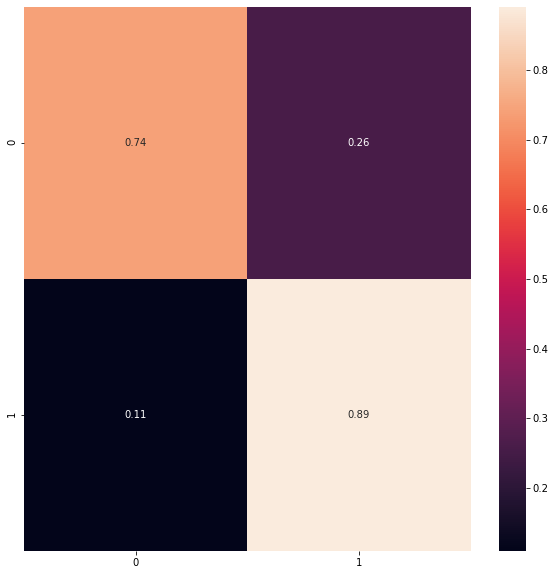

In [100]:
import seaborn as sns
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cm, annot=True)

Text(0.5, 0, 'Relative Importance')

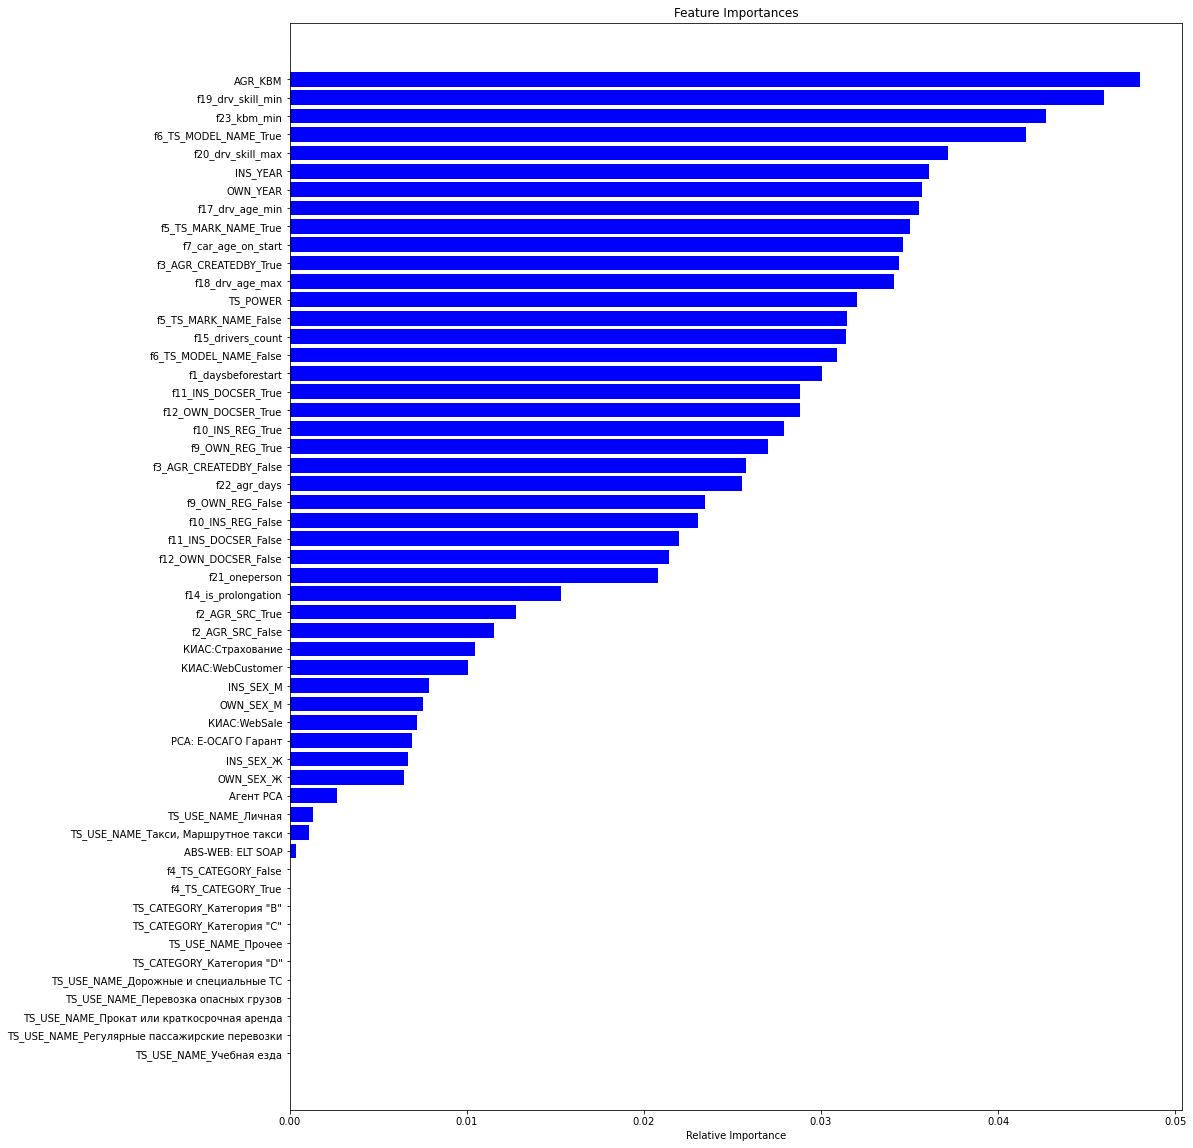

In [74]:
features=Xs.columns
importances = modelet.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 20))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
# попробуем CatBoost
rac = 0
for i in range(40):
    for d in range(12):
        modelcb = CatBoostClassifier(
        loss_function='Logloss',
        depth=d+1,
        iterations=i+10,
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent',
        allow_writing_files=False
    )
        modelcb.fit(Xs_train, ys_train)
        pred = modelcb.predict(Xs_test)
        r = roc_auc_score(ys_test, pred)
        if r>rac:
            rac = r
            print('depth: ', d+1, 'iterations: ', i+10, 'RAC: ', r)

depth:  1 iterations:  10 RAC:  0.6006805006133202
depth:  2 iterations:  10 RAC:  0.6097198520833397
depth:  3 iterations:  10 RAC:  0.6124655475945548
depth:  3 iterations:  11 RAC:  0.612881675669029
depth:  4 iterations:  11 RAC:  0.6152742246521768
depth:  2 iterations:  14 RAC:  0.617084194331061
depth:  3 iterations:  18 RAC:  0.6189563957760377
depth:  3 iterations:  20 RAC:  0.6192788013112158
depth:  3 iterations:  21 RAC:  0.6204334629953423
depth:  2 iterations:  29 RAC:  0.620693636764428
